In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [3]:
raw_crime_data = pd.read_csv("crimes_-_2022.csv")
raw_crime_data.shape

(239043, 22)

In [4]:
raw_crime_data.isnull().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description     881
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                      10
Community Area             0
FBI Code                   0
X Coordinate            4107
Y Coordinate            4107
Year                       0
Updated On                 0
Latitude                4107
Longitude               4107
Location                4107
dtype: int64

### Full data preparation
*By Alyssa Shou*

In [5]:
# convert the Date column to datetime object
raw_crime_data.Date.dtypes

dtype('O')

In [7]:
# converting the date column to datetime objects #
raw_crime_data['Date'] = raw_crime_data['Date'].apply(pd.to_datetime)
type(raw_crime_data.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

### Crime type preparation
*By Alyssa Shou*

Since there are 881 NA values in Location Description, I had to drop them because the location of the crimes is necessary for my analysis. No other changes were made to other columns before I began slicing the data I specifically needed for EDA.

In [8]:
# Dropping a very small percentage of the data so general trends should not change
881/239043

0.0036855293817430338

In [9]:
time_data = raw_crime_data.dropna(subset = ['Location Description'])
time_data.shape

(238162, 22)

### Theft data preparation
*By Grace Chang*

The following data preparation steps served to subset theft data and subsequently merge it with community area data in order to run further analyses on theft occurrence across community areas.

1. Since the community areas in the original dataset are labeled by their numeric code, I merged it with another dataset to pair these codes with their corresponding community names. 

2. In the original dataset, numeric codes needed to be converted to double digits so that the merge could take place. All observations of "The Loop" were also cleaned so that their format was consistent with the rest of the community area names. 

In [10]:
theft_data = raw_crime_data.loc[(raw_crime_data['Primary Type'] == 'THEFT'), :]

In [11]:
community_areas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
community_areas = community_areas[0]
community_areas.columns = [col[0] for col in community_areas.columns]
community_areas.columns = ["No.", "Community Name", "Population", "Area (sqmi)", "Area (sqkm)", "Density (sqmi)", "Density (sqkm)"]
community_areas.head() # Formatting the Community Areas dataset to prepare it for merging

,No.,Community Name,Population,Area (sqmi),Area (sqkm),Density (sqmi),Density (sqkm)
0,01,Rogers Park,55628,1.84,4.77,30232.61,11672.81
1,02,West Ridge,77122,3.53,9.14,21847.59,8435.36
2,03,Uptown,57182,2.32,6.01,24647.41,9516.37
3,04,Lincoln Square,40494,2.56,6.63,15817.97,6107.32
4,05,North Center,35114,2.05,5.31,17128.78,6613.42


In [12]:
theft_data.loc[:,'Community Area'] = theft_data['Community Area'].apply(lambda x: f'{int(x):02d}' if isinstance(x, (int, str)) and str(x).isdigit() else x)
theft_data['Community Area'].value_counts().head(6) # Checking that the single digit codes were indeed converted to double digit format

Community Area
08    4251
32    3464
28    3373
24    2681
06    2268
25    1823
Name: count, dtype: int64

In [13]:
theft_data.loc[:,'Community Area'] = theft_data['Community Area'].astype(str)
theft_community_data = theft_data.merge(community_areas, left_on = 'Community Area', right_on = 'No.', how = 'left')
theft_community_data['Community Name'] = theft_community_data['Community Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))
theft_community_data.head(3) # The newly merged dataset with cleaned community names

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Latitude,Longitude,Location,No.,Community Name,Population,Area (sqmi),Area (sqkm),Density (sqmi),Density (sqkm)
0,13209277,JG422539,2022-08-15 09:00:00,0000X W JACKSON BLVD,0810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,NaN,NaN,NaN,32,The Loop,42298,1.65,4.27,25635.15,9897.73
1,12678035,JF216671,2022-04-22 23:30:00,044XX N BROADWAY,0810,THEFT,OVER $500,APARTMENT,True,True,...,41.962247,-87.65546,"(41.962247182, -87.6554598)",03,Uptown,57182,2.32,6.01,24647.41,9516.37
2,12713141,JF259485,2022-05-29 00:00:00,014XX S MUSEUM CAMPUS DR,0870,THEFT,POCKET-PICKING,SPORTS ARENA / STADIUM,False,False,...,NaN,NaN,NaN,33,Near South Side,28795,1.78,4.61,16176.97,6245.93


*By Ryu Kimiko*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need are analyzing house price, we derived some new variables *(from existing variables)* that intuitively seem to be associated with house price. 

2. We have created a standardized version of the dataset, as we are computing Euclidean distances to find houses similar to a given house

### Arrest data preparation

*By Paisley Lucier*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since I will be considering arrest proportion by district, I will look at the distribution of district.

2. We have created a standardized version of the dataset, as we are computing Euclidean distances to find houses similar to a given house

In [42]:
raw_crime_data.District.value_counts()

8     14811
6     14709
12    14353
4     13948
11    13474
1     13058
18    12444
19    12259
25    11955
3     11937
2     11799
9     10375
7     10323
10     9970
5      9785
16     9242
24     8474
15     8310
14     8166
22     7674
17     6996
20     4967
31       14
Name: District, dtype: int64

In [14]:
14 / raw_crime_data.shape[0]

5.856686872236376e-05

In [16]:
# making a new column that bins the data into 'side' of Chicago--source:

arrest_data = raw_crime_data.copy()
arrest_data['Side'] = arrest_data.District
arrest_data['Side'] = arrest_data['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', 31: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})
arrest_data.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Side
0,12589893,JF109865,2022-01-11 15:00:00,087XX S KINGSTON AVE,1565,SEX OFFENSE,INDECENT SOLICITATION OF A CHILD,RESIDENCE,False,True,...,46,17,1194660.0,1847481.0,2022,09/14/2023 03:41:59 PM,41.736409,-87.562410,"(41.736409029, -87.562410309)",South
1,12592454,JF113025,2022-01-14 15:55:00,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,68,26,1170805.0,1860170.0,2022,09/14/2023 03:41:59 PM,41.771782,-87.649437,"(41.771782439, -87.649436929)",South
2,12785595,JF346553,2022-08-05 21:00:00,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,69,17,1185135.0,1857211.0,2022,09/14/2023 03:41:59 PM,41.763338,-87.597001,"(41.763337967, -87.597001131)",Central


In [45]:
# considering that district 31 has only 14 observations (which is 5.856686872236376e-03% of the observations),
#and is split between the North and South side on the source map, I considered only the subset of crimes where
# the district was not 31
arrest_data = arrest_data.loc[arrest_data['District'] != 31, :]


In [46]:
# read sentiments data
sentiments = pd.read_csv('Police_Sentiment_Scores.csv')

# convert start date to datetime, subset only the values from 2022

sentiments['START_DATE'] = pd.to_datetime(sentiments['START_DATE'])
sentiments['START_DATE'] = sentiments['START_DATE'].map(lambda x: True if x.year == 2022 else False)
sentiments_2022 = sentiments.loc[sentiments['START_DATE'] == True, :]

# also subset only the general columns
sentiments_2022 = sentiments_2022.loc[:, ['DISTRICT', 'SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN']]
sentiments_2022

FileNotFoundError: [Errno 2] No such file or directory: 'Police_Sentiment_Scores.csv'

### CTA data preparation
*By Grace Shao*

Implementing the following steps allowed for missing location data to be removed and community area names to be included with their corresponding numbers for enhanced readibility and analysis. 

1. After subsetting the data to include only crimes that occurred at CTA stations, I removed observations with missing longitude and latitude values. Location data will be used in my data analysis, and removing NA values ensures a clean dataset. Since only around 1% of the CTA data was removed, this step does not have a significant impact on my conclusions. 
2. Next, I added the names of the community areas. Originally, the column in the raw dataset included the numeric codes of the areas, but not their names. I merged my data with a Wikipedia table that included both to aid in my analysis.
3. After merging, all observations of "The Loop" have extra characters at the end. Removing those extra characters ensured that it matched the other community areas' names. 

In [47]:
crimesCTA = raw_crime_data.loc[raw_crime_data['Location Description'].apply(lambda x: 'CTA' in str(x) and 'CTA BUS' not in str(x) 
                                                            and 'CTA PARKING LOT / GARAGE / OTHER PROPERTY' not in str(x)), :]

# Drop NA location values (longitude and latitude)
numberRows = crimesCTA.shape[0]
numberLongitudeNA = crimesCTA['Longitude'].isna().sum()
numberLatitudeNA = crimesCTA['Latitude'].isna().sum()
print("Number of missing longitudes:", numberLongitudeNA, "Number of missing latitudes:", numberLatitudeNA)
print("Percentage of missing values out of all values is", numberLongitudeNA/numberRows*100, "%")

crimesCTA.dropna(subset=['Longitude'], inplace=True)
crimesCTA.dropna(subset=['Latitude'], inplace=True)

Number of missing longitudes: 31 Number of missing latitudes: 31
Percentage of missing values out of all values is 1.2684124386252045 %


In [48]:
# Add a column with the names of the community areas instead of just the number
communityAreas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
communityAreas = communityAreas[0]
communityAreas.columns = [col[0] for col in communityAreas.columns]
communityAreas = communityAreas.iloc[:-1, [0,1]]
communityAreas.rename(columns={'No.': 'Community Area'}, inplace=True)
communityAreas.head()

,Community Area,Name
0,01,Rogers Park
1,02,West Ridge
2,03,Uptown
3,04,Lincoln Square
4,05,North Center


In [49]:
crimesCTA['Community Area'] = crimesCTA['Community Area'].astype('int64')
communityAreas['Community Area'] = communityAreas['Community Area'].astype('int64')
crimesCTA = pd.merge(crimesCTA, communityAreas, on='Community Area', how='inner')
crimesCTA['Name'] = crimesCTA['Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))

In [50]:
# Check to make sure the names are accurate
crimesCTA.loc[:, ['Community Area', 'Name']].iloc[-5:]

,Community Area,Name
2408,70,Ashburn
2409,23,Humboldt Park
2410,9,Edison Park
2411,41,Hyde Park
2412,66,Chicago Lawn


## Set graph settings

In [51]:
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]

sns.set_palette(sns.color_palette(colors))

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Analysis 1
*By \<Alyssa Shou>*

**Graphing the number of crimes by hour as an initial starting point to determine analysis time frames**

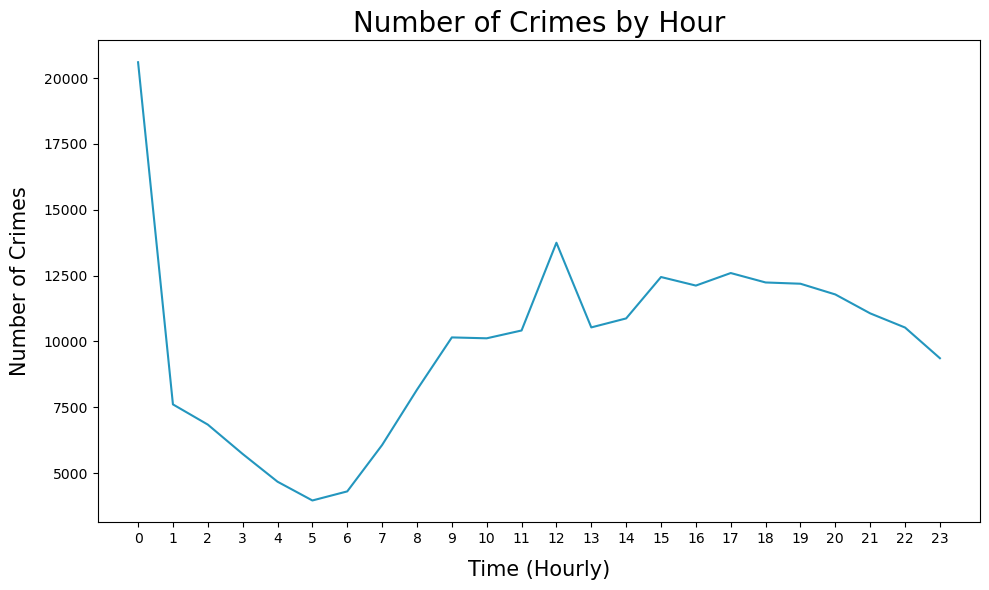

In [95]:
# Round times down to nearest hour
time_data['hourly_time'] = time_data['Date'].dt.floor('H').dt.time

crime_counts = time_data['hourly_time'].value_counts().sort_index()
crime_counts = crime_counts.to_frame(name = 'Count').reset_index()

plt.figure(figsize=(10, 6))
bx = sns.lineplot(x= crime_counts.index, y=crime_counts.Count, color = "#2396be")
step = len(crime_counts.index) // 24 
plt.xticks(range(0, len(crime_counts.index), step))
plt.xlabel('Time (Hourly)', fontsize = 15, labelpad=10)
plt.ylabel('Number of Crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Hour', fontsize = 20)
plt.tight_layout()
plt.show()

## Morning Rush

In [96]:
#slicing the data to only look at 6 am to 9 am
morning_rush = time_data.loc[(time_data['Date'].dt.hour >= 6) & (time_data['Date'].dt.hour < 9)]

### Morning Rush Crime Types

In [97]:
#top 10 types of crime from 6 am to 9 am
combination_mr = morning_rush.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_mr = combination_mr.sort_values(by = 'Count', ascending = False).head(10)
combination_mr['Type'] = combination_mr['Primary Type'] + " " + combination_mr['Description']
combination_mr

,Primary Type,Description,Count,Type
205,THEFT,OVER $500,1710,THEFT OVER $500
201,THEFT,$500 AND UNDER,1601,THEFT $500 AND UNDER
36,BATTERY,DOMESTIC BATTERY SIMPLE,1576,BATTERY DOMESTIC BATTERY SIMPLE
103,MOTOR VEHICLE THEFT,AUTOMOBILE,1504,MOTOR VEHICLE THEFT AUTOMOBILE
52,CRIMINAL DAMAGE,TO VEHICLE,1312,CRIMINAL DAMAGE TO VEHICLE
16,ASSAULT,SIMPLE,1055,ASSAULT SIMPLE
50,CRIMINAL DAMAGE,TO PROPERTY,1022,CRIMINAL DAMAGE TO PROPERTY
39,BATTERY,SIMPLE,890,BATTERY SIMPLE
208,THEFT,RETAIL THEFT,692,THEFT RETAIL THEFT
41,BURGLARY,FORCIBLE ENTRY,396,BURGLARY FORCIBLE ENTRY


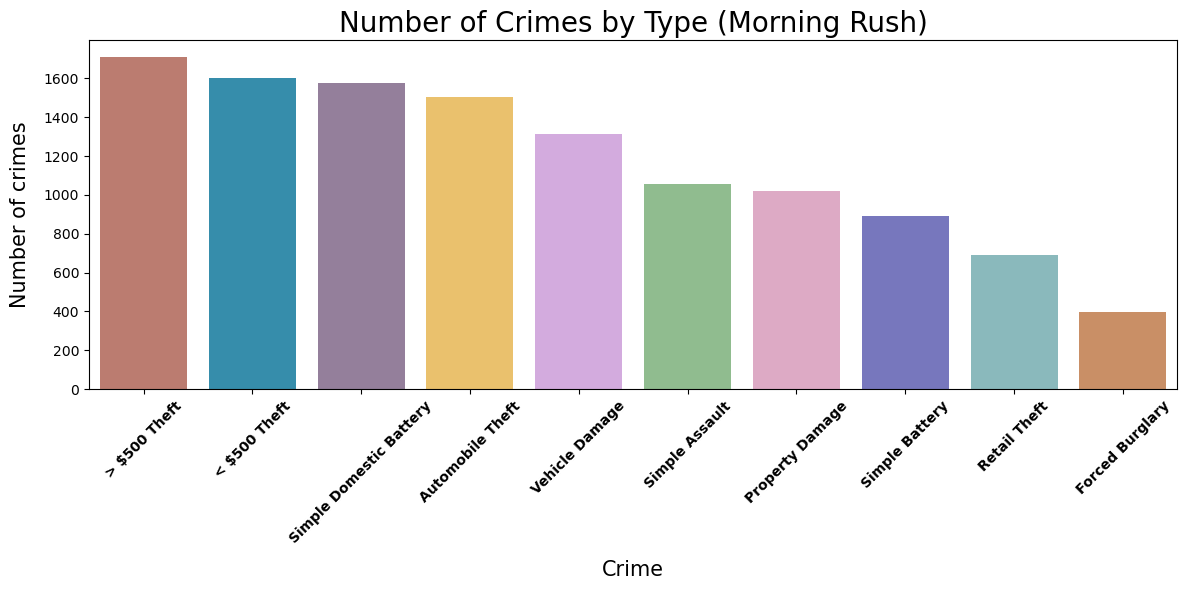

In [98]:
#barplot of crime types
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= combination_mr.Type, y = combination_mr.Count, palette = colors)
plt.xlabel('Crime', fontsize = 15, labelpad=10)
ax.set_xticklabels(labels = ['> $500 Theft', '< $500 Theft', 'Simple Domestic Battery', 'Automobile Theft', 
                             'Vehicle Damage', 'Simple Assault', 'Property Damage', 'Simple Battery', 
                             'Retail Theft', 'Forced Burglary'])
plt.ylabel('Number of crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Type (Morning Rush)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold')
plt.tight_layout()
plt.show()

### Morning Rush Locations

In [99]:
mr_locations = morning_rush['Location Description'].value_counts().head(10)
locations_mr = mr_locations.to_frame(name = 'Count').reset_index()
locations_mr

,index,Count
0,STREET,4989
1,APARTMENT,3990
2,RESIDENCE,2448
3,PARKING LOT / GARAGE (NON RESIDENTIAL),765
4,SIDEWALK,714
5,SMALL RETAIL STORE,431
6,COMMERCIAL / BUSINESS OFFICE,305
7,ALLEY,301
8,OTHER (SPECIFY),290
9,RESIDENCE - GARAGE,283


In [100]:
locations_mr['Count'].sum()

14516

In [101]:
#percent of top 10 crimes in public locations
(4989+765+714+431+301)*100/14516

49.60044089280794

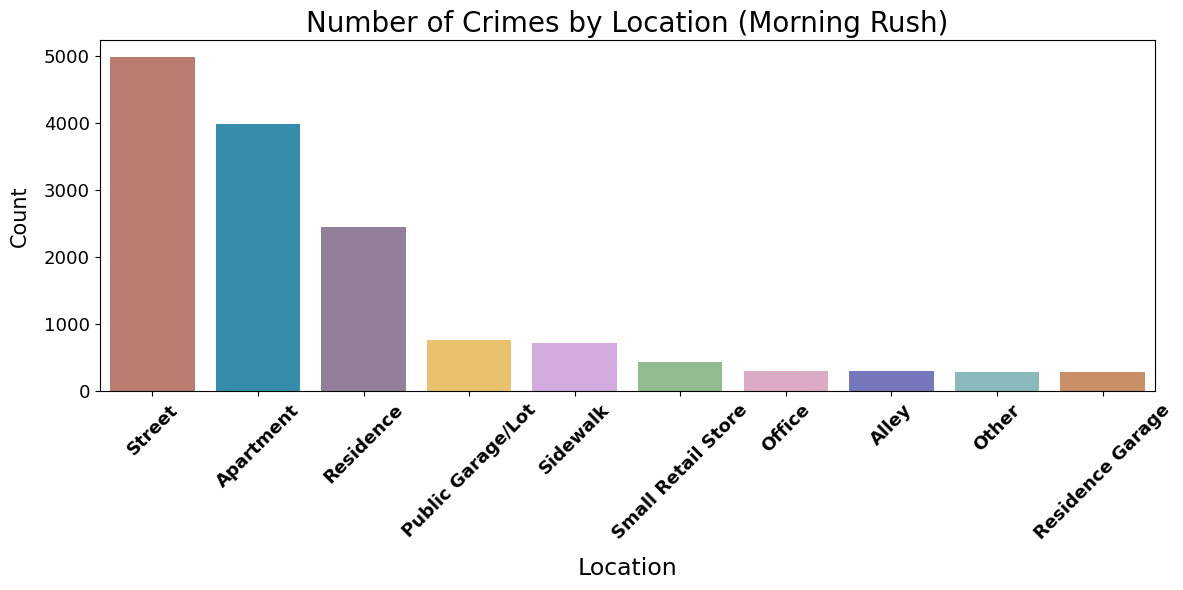

In [102]:
#barplot of crime locations
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= locations_mr.index, y = locations_mr.Count, palette = colors)
plt.xlabel('Location', fontsize = 17, labelpad=10)
ax.set_xticklabels(labels = ['Street', 'Apartment', 'Residence', 'Public Garage/Lot', 
                             'Sidewalk', 'Small Retail Store',  'Office', 'Alley', 'Other', 
                             'Residence Garage'])
plt.ylabel('Count', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Location (Morning Rush)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold', fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

### Morning Rush Violence

In [103]:
#IUCR code <= 558 + codes 051A, 051B, 041A, 041B, 031A, 031B are considered violent

# Function to determine if a crime is violent based on IUCR code
def is_violent(iucr_code):
    # Define extra IUCR codes that indicate violent crimes
    violent_iucr = ['051A', '051B', '041A', '041B', '031A', '031B']
    
    if iucr_code.isdigit():
        return int(iucr_code) <= 558
    else:
        return iucr_code in violent_iucr

morning_rush['Violent?'] = morning_rush['IUCR'].apply(lambda x: is_violent(x))
morning_rush.head() #check that column is added

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,hourly_time,Violent?
13,12829768,JF398130,2022-09-16 07:00:00,030XX N WHIPPLE ST,0320,ROBBERY,STRONG ARM - NO WEAPON,APARTMENT,False,False,...,03,1155521.0,1919887.0,2022,09/15/2023 03:41:25 PM,41.935972,-87.703859,"(41.935972475, -87.703858758)",07:00:00,True
18,13211226,JF308371,2022-06-07 07:00:00,002XX S ASHLAND AVE,5000,OTHER OFFENSE,OTHER CRIME AGAINST PERSON,GOVERNMENT BUILDING / PROPERTY,False,False,...,26,NaN,NaN,2022,09/15/2023 03:42:23 PM,NaN,NaN,NaN,07:00:00,False
28,12784904,JF345855,2022-07-31 07:00:00,021XX N SPRINGFIELD AVE,1754,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,APARTMENT,False,True,...,02,1150028.0,1914097.0,2022,09/16/2023 03:41:56 PM,41.920193,-87.724197,"(41.920193109, -87.724197302)",07:00:00,False
31,12931878,JF521379,2022-12-24 08:00:00,021XX S MARSHALL BLVD,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",RESIDENCE - PORCH / HALLWAY,True,True,...,04B,1157031.0,1889686.0,2022,09/22/2023 03:41:26 PM,41.853068,-87.699130,"(41.853067647, -87.69912978)",08:00:00,True
39,13213753,JG427020,2022-01-01 06:00:00,014XX N SEDGWICK ST,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,APARTMENT,False,False,...,11,NaN,NaN,2022,09/18/2023 03:42:32 PM,NaN,NaN,NaN,06:00:00,False


In [104]:
violent_crimes_percentage = (morning_rush['Violent?'].sum() / len(morning_rush)) * 100

print(f"The percentage of violent crimes is: {violent_crimes_percentage:.2f}%")

The percentage of violent crimes is: 23.69%


## Noon

In [105]:
noon = time_data.loc[time_data['Date'].dt.hour == 12]

### Noon Crime Types

In [106]:
combination_noon = noon.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_noon = combination_noon.sort_values(by = 'Count', ascending = False).head(10)
combination_noon['Type'] = combination_noon['Primary Type'] + " " + combination_noon['Description']
combination_noon

,Primary Type,Description,Count,Type
203,THEFT,$500 AND UNDER,1219,THEFT $500 AND UNDER
207,THEFT,OVER $500,1102,THEFT OVER $500
34,BATTERY,SIMPLE,799,BATTERY SIMPLE
16,ASSAULT,SIMPLE,779,ASSAULT SIMPLE
32,BATTERY,DOMESTIC BATTERY SIMPLE,724,BATTERY DOMESTIC BATTERY SIMPLE
96,MOTOR VEHICLE THEFT,AUTOMOBILE,696,MOTOR VEHICLE THEFT AUTOMOBILE
210,THEFT,RETAIL THEFT,642,THEFT RETAIL THEFT
44,CRIMINAL DAMAGE,TO PROPERTY,516,CRIMINAL DAMAGE TO PROPERTY
46,CRIMINAL DAMAGE,TO VEHICLE,500,CRIMINAL DAMAGE TO VEHICLE
67,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,430,DECEPTIVE PRACTICE FINANCIAL IDENTITY THEFT OV...


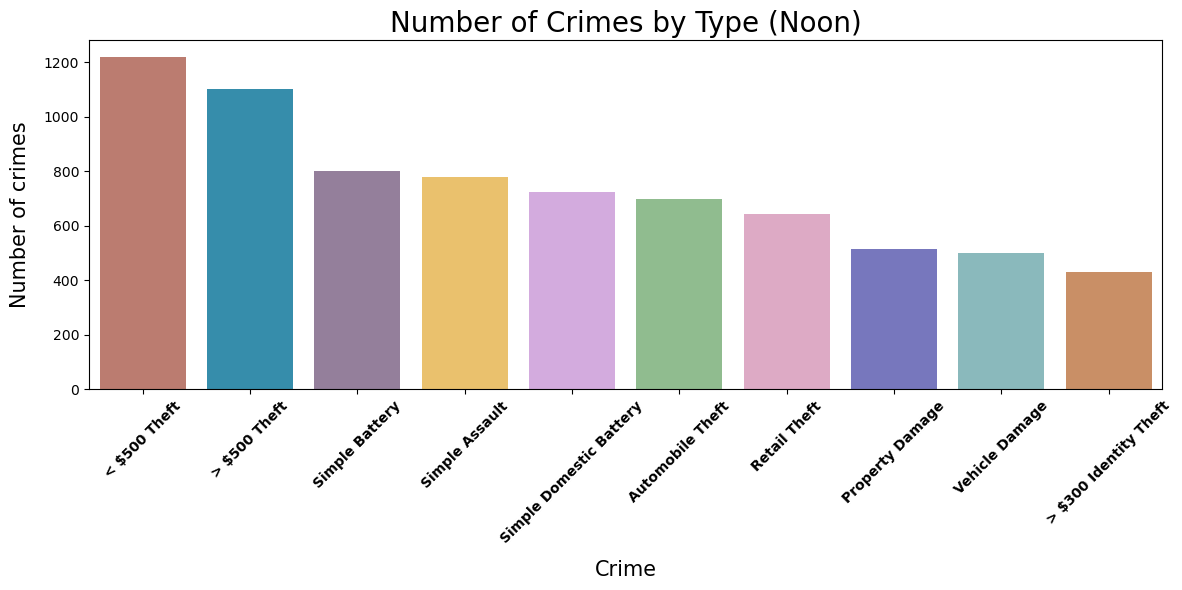

In [107]:
#barplot of crime types
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= combination_noon.Type, y = combination_noon.Count, palette = colors)
plt.xlabel('Crime', fontsize = 15, labelpad=10)
ax.set_xticklabels(labels = ['< $500 Theft', '> $500 Theft', 'Simple Battery', 'Simple Assault', 
                             'Simple Domestic Battery', 'Automobile Theft', 'Retail Theft', 'Property Damage', 
                             'Vehicle Damage', '> $300 Identity Theft'])
plt.ylabel('Number of crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Type (Noon)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold')
plt.tight_layout()
plt.show()

### Noon Locations

In [108]:
noon_locations = noon['Location Description'].value_counts().head(10)
locations_noon = noon_locations.to_frame(name = 'Count').reset_index()
locations_noon

,index,Count
0,APARTMENT,2840
1,STREET,2729
2,RESIDENCE,2342
3,SIDEWALK,627
4,SMALL RETAIL STORE,576
5,PARKING LOT / GARAGE (NON RESIDENTIAL),488
6,COMMERCIAL / BUSINESS OFFICE,327
7,OTHER (SPECIFY),319
8,RESTAURANT,284
9,SCHOOL - PUBLIC BUILDING,246


In [109]:
locations_noon['Count'].sum()

10778

In [110]:
#percent of top 10 crimes in public locations
(2729+627+576+488+284+246)*100/10778

45.92688810539989

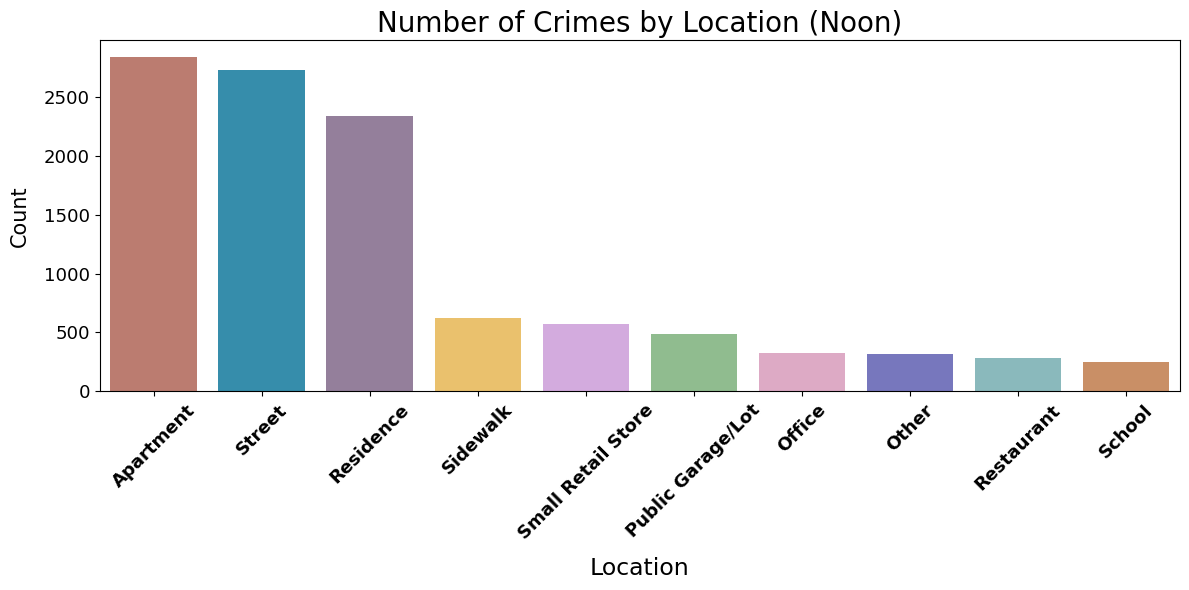

In [111]:
#barplot of crime locations
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= locations_noon.index, y = locations_noon.Count, palette = colors)
plt.xlabel('Location', fontsize = 17, labelpad=10)
ax.set_xticklabels(labels = ['Apartment', 'Street', 'Residence', 'Sidewalk', 
                            'Small Retail Store', 'Public Garage/Lot', 'Office', 'Other', 
                            'Restaurant', 'School'])
plt.ylabel('Count', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Location (Noon)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold', fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

### Noon Violence

In [113]:
noon['Violent?'] = noon['IUCR'].apply(lambda x: is_violent(x))
noon.head() #check that column is added

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,hourly_time,Violent?
15,12885646,JF465749,2022-11-05 12:49:00,044XX W RICE ST,0620,BURGLARY,UNLAWFUL ENTRY,WAREHOUSE,True,False,...,05,1146532.0,1905297.0,2022,09/15/2023 03:41:25 PM,41.896112,-87.737267,"(41.896112422, -87.737267038)",12:00:00,False
27,12767058,JF324850,2022-07-03 12:00:00,019XX N LOWELL AVE,1754,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,APARTMENT,False,True,...,02,1147084.0,1912456.0,2022,09/16/2023 03:41:56 PM,41.915747,-87.735056,"(41.915746919, -87.735056247)",12:00:00,False
41,13184937,JG393538,2022-08-01 12:00:00,020XX W HOMER ST,1120,DECEPTIVE PRACTICE,FORGERY,APARTMENT,False,True,...,10,NaN,NaN,2022,08/23/2023 03:41:55 PM,NaN,NaN,NaN,12:00:00,False
55,12792072,JF354522,2022-08-12 12:00:00,032XX N DAMEN AVE,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,True,False,...,05,1162437.0,1921720.0,2022,09/20/2023 03:41:26 PM,41.940860,-87.678390,"(41.940860174, -87.678390398)",12:00:00,False
57,12616294,JF142268,2022-02-12 12:46:00,054XX S LOOMIS BLVD,031A,ROBBERY,ARMED - HANDGUN,STREET,True,False,...,03,1167920.0,1868745.0,2022,11/13/2023 03:41:12 PM,41.795376,-87.659766,"(41.795375753, -87.659766174)",12:00:00,True


In [114]:
violent_crimes_percentage = (noon['Violent?'].sum() / len(noon)) * 100

print(f"The percentage of violent crimes is: {violent_crimes_percentage:.2f}%")

The percentage of violent crimes is: 18.88%


## Evening Rush Hour

In [115]:
evening_rush = time_data.loc[(time_data['Date'].dt.hour >= 16) & (time_data['Date'].dt.hour < 19)]

### Evening Rush Crime Types

In [116]:
combination_er = evening_rush.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_er = combination_er.sort_values(by = 'Count', ascending = False).head(10)
combination_er['Type'] = combination_er['Primary Type'] + " " + combination_er['Description']
combination_er

,Primary Type,Description,Count,Type
237,THEFT,OVER $500,3287,THEFT OVER $500
232,THEFT,$500 AND UNDER,3178,THEFT $500 AND UNDER
115,MOTOR VEHICLE THEFT,AUTOMOBILE,2785,MOTOR VEHICLE THEFT AUTOMOBILE
37,BATTERY,DOMESTIC BATTERY SIMPLE,2563,BATTERY DOMESTIC BATTERY SIMPLE
17,ASSAULT,SIMPLE,2511,ASSAULT SIMPLE
40,BATTERY,SIMPLE,2328,BATTERY SIMPLE
53,CRIMINAL DAMAGE,TO VEHICLE,2240,CRIMINAL DAMAGE TO VEHICLE
240,THEFT,RETAIL THEFT,1995,THEFT RETAIL THEFT
51,CRIMINAL DAMAGE,TO PROPERTY,1680,CRIMINAL DAMAGE TO PROPERTY
235,THEFT,FROM BUILDING,871,THEFT FROM BUILDING


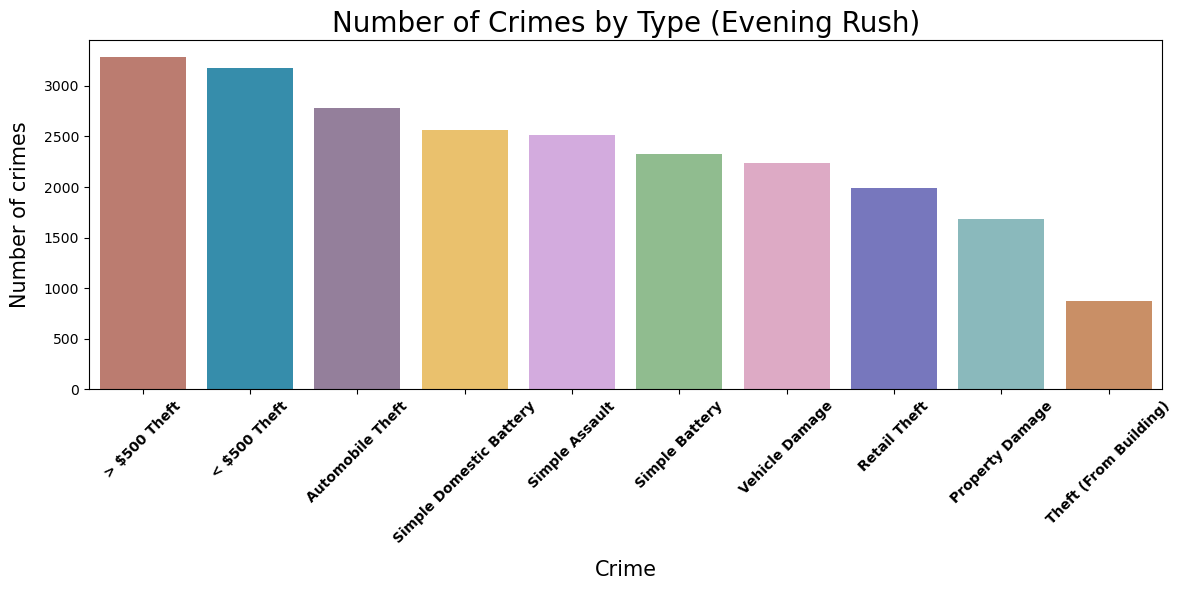

In [117]:
#barplot of crime types
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= combination_er.Type, y = combination_er.Count, palette = colors)
plt.xlabel('Crime', fontsize = 15, labelpad=10)
ax.set_xticklabels(labels = ['> $500 Theft', '< $500 Theft', 'Automobile Theft', 'Simple Domestic Battery',
                             'Simple Assault', 'Simple Battery', 'Vehicle Damage', 
                             'Retail Theft', 'Property Damage', 'Theft (From Building)'])
plt.ylabel('Number of crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Type (Evening Rush)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold')
plt.tight_layout()
plt.show()

### Evening Rush Locations

In [118]:
er_locations = evening_rush['Location Description'].value_counts().head(10)
locations_er = er_locations.to_frame(name = 'Count').reset_index()
locations_er

,index,Count
0,STREET,10651
1,APARTMENT,6168
2,RESIDENCE,4289
3,SIDEWALK,1982
4,PARKING LOT / GARAGE (NON RESIDENTIAL),1717
5,SMALL RETAIL STORE,1679
6,RESTAURANT,993
7,DEPARTMENT STORE,856
8,ALLEY,759
9,OTHER (SPECIFY),555


In [119]:
locations_er['Count'].sum()

29649

In [120]:
#Percentage of top 10 crimes in public locations
(10651+1982+1717+1679+993+856+759)*100/29649

62.85878107187426

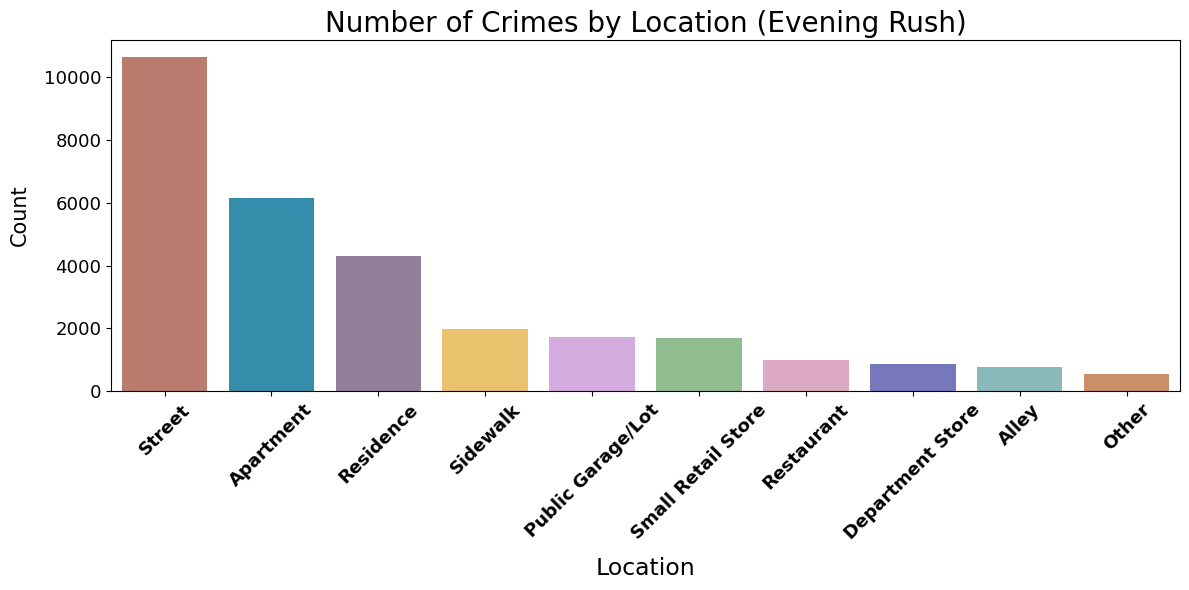

In [121]:
#barplot of crime locations
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= locations_er.index, y = locations_er.Count, palette = colors)
plt.xlabel('Location', fontsize = 17, labelpad=10)
ax.set_xticklabels(labels = ['Street', 'Apartment', 'Residence', 'Sidewalk', 'Public Garage/Lot', 
                             'Small Retail Store', 'Restaurant', 'Department Store', 'Alley', 'Other'])
plt.ylabel('Count', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Location (Evening Rush)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold', fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

In [122]:
evening_rush['Violent?'] = evening_rush['IUCR'].apply(lambda x: is_violent(x))
evening_rush.head() #check that column is added

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,hourly_time,Violent?
16,12893219,JF474959,2022-11-14 17:00:00,012XX S INDEPENDENCE BLVD,0325,ROBBERY,VEHICULAR HIJACKING,STREET,True,False,...,03,1151289.0,1894080.0,2022,09/15/2023 03:41:25 PM,41.865240,-87.720090,"(41.865239745, -87.720089778)",17:00:00,True
17,13210651,JG424030,2022-12-29 17:00:00,026XX W 19TH ST,1563,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,OTHER (SPECIFY),False,False,...,17,1159021.0,1890619.0,2022,11/15/2023 03:41:31 PM,41.855587,-87.691800,"(41.855587334, -87.691800214)",17:00:00,False
19,12928785,JF517668,2022-12-20 16:30:00,076XX S MAPLEWOOD AVE,1020,ARSON,BY FIRE,RESIDENCE - GARAGE,True,False,...,09,1160707.0,1853794.0,2022,08/23/2023 03:40:54 PM,41.754500,-87.686629,"(41.754500145, -87.686628806)",16:00:00,False
22,12602374,JF125017,2022-01-26 17:45:00,069XX N CLARK ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,08B,1163566.0,1945922.0,2022,09/16/2023 03:41:56 PM,42.007248,-87.673556,"(42.007247653, -87.673555844)",17:00:00,True
29,12812832,JF378884,2022-06-23 17:35:00,026XX N MOODY AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,True,...,02,1134954.0,1916928.0,2022,09/16/2023 03:41:56 PM,41.928242,-87.779516,"(41.928242161, -87.779515528)",17:00:00,True


In [123]:
violent_crimes_percentage = (evening_rush['Violent?'].sum() / len(evening_rush)) * 100

print(f"The percentage of violent crimes is: {violent_crimes_percentage:.2f}%")

The percentage of violent crimes is: 23.93%


## Midnight

In [124]:
midnight = time_data.loc[time_data['Date'].dt.hour == 0]

In [125]:
combination_midnight = midnight.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_midnight = combination_midnight.sort_values(by = 'Count', ascending = False).head(10)
combination_midnight['Type'] = combination_midnight['Primary Type'] + " " + combination_midnight['Description']
combination_midnight

,Primary Type,Description,Count,Type
210,THEFT,OVER $500,1738,THEFT OVER $500
205,THEFT,$500 AND UNDER,1564,THEFT $500 AND UNDER
33,BATTERY,DOMESTIC BATTERY SIMPLE,1503,BATTERY DOMESTIC BATTERY SIMPLE
48,CRIMINAL DAMAGE,TO VEHICLE,1323,CRIMINAL DAMAGE TO VEHICLE
108,MOTOR VEHICLE THEFT,AUTOMOBILE,1317,MOTOR VEHICLE THEFT AUTOMOBILE
46,CRIMINAL DAMAGE,TO PROPERTY,1104,CRIMINAL DAMAGE TO PROPERTY
35,BATTERY,SIMPLE,882,BATTERY SIMPLE
15,ASSAULT,SIMPLE,732,ASSAULT SIMPLE
74,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,708,DECEPTIVE PRACTICE FINANCIAL IDENTITY THEFT OV...
75,DECEPTIVE PRACTICE,FORGERY,466,DECEPTIVE PRACTICE FORGERY


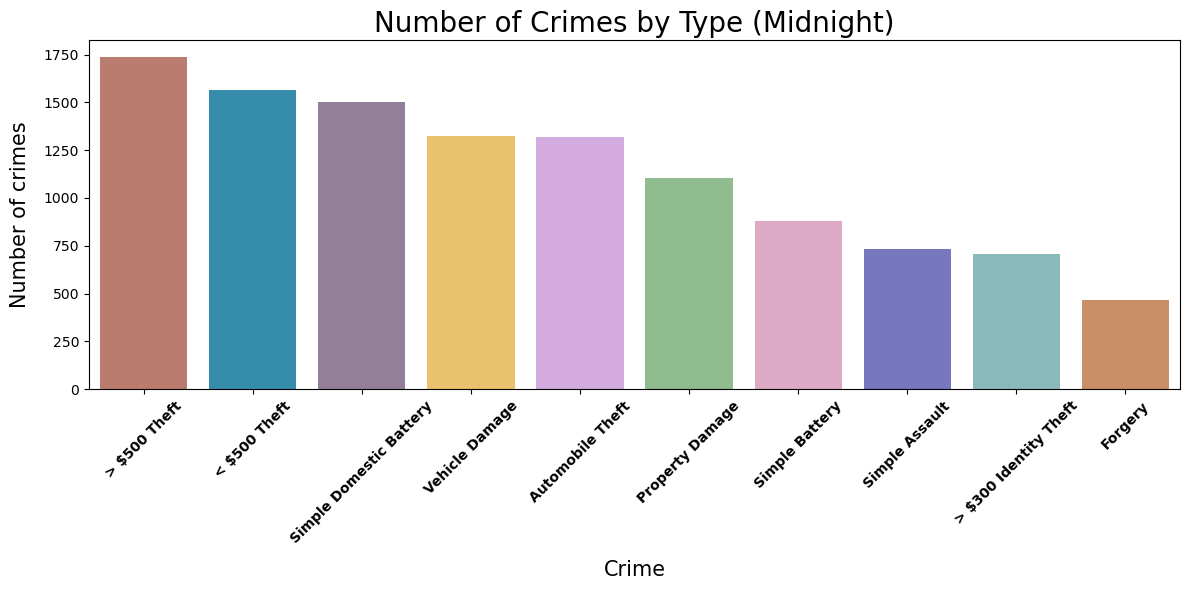

In [126]:
#barplot of crime types
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= combination_midnight.Type, y = combination_midnight.Count, palette = colors)
plt.xlabel('Crime', fontsize = 15, labelpad=10)
ax.set_xticklabels(labels = ['> $500 Theft', '< $500 Theft', 'Simple Domestic Battery', 'Vehicle Damage', 
                             'Automobile Theft', 'Property Damage', 'Simple Battery', 'Simple Assault', 
                             '> $300 Identity Theft', 'Forgery'])
plt.ylabel('Number of crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Type (Midnight)', fontsize = 20)
plt.xticks(rotation=45, weight = 'bold')
#plt.xticks(x, weight = 'bold')

plt.tight_layout()
plt.show()

### Midnight Locations

In [127]:
midnight_locations = midnight['Location Description'].value_counts().head(10)
locations_midnight = midnight_locations.to_frame(name = 'Count').reset_index()
locations_midnight

,index,Count
0,STREET,5613
1,APARTMENT,4658
2,RESIDENCE,3744
3,SIDEWALK,794
4,PARKING LOT / GARAGE (NON RESIDENTIAL),615
5,OTHER (SPECIFY),432
6,ALLEY,404
7,COMMERCIAL / BUSINESS OFFICE,404
8,SMALL RETAIL STORE,302
9,RESTAURANT,269


In [128]:
locations_midnight['Count'].sum()

17235

In [129]:
#Percentage of top 10 crimes in public locations
(5613+794+615+404+302+269)*100/17235

46.399767914128226

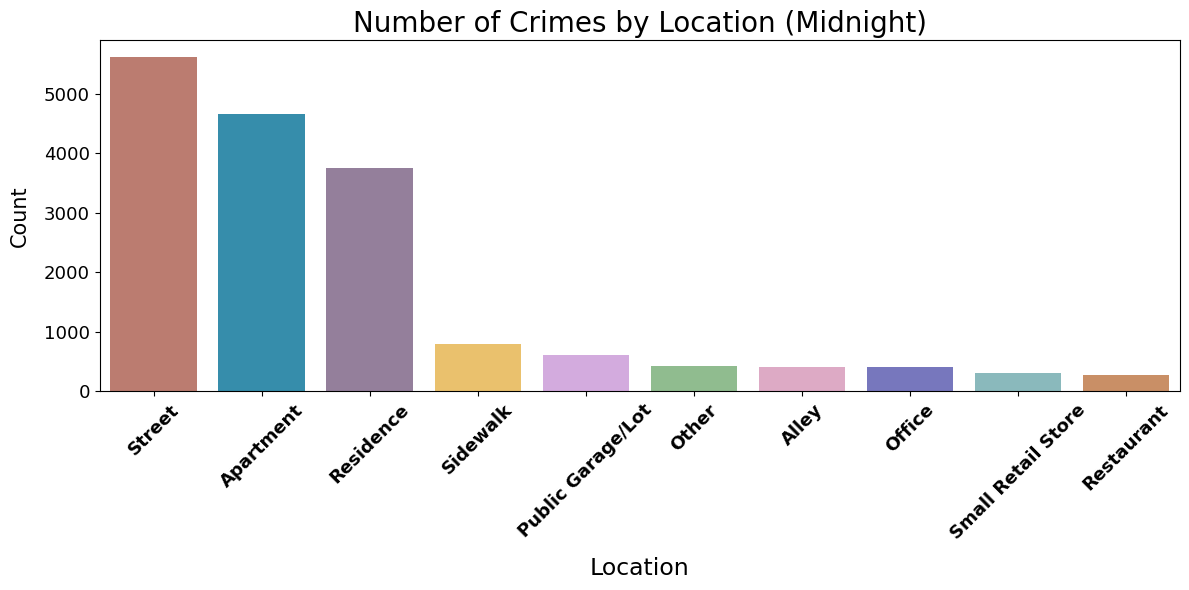

In [130]:
#barplot of crime locations
plt.figure(figsize=(12, 6))
ax = sns.barplot(x= locations_midnight.index, y = locations_midnight.Count, palette = colors)
#ax = sns.barplot(x= locations_midnight.Count, y = locations_midnight.index, palette = colors, orient = "h")

plt.xlabel('Location', fontsize = 17, labelpad=10)
ax.set_xticklabels(labels = ['Street', 'Apartment', 'Residence', 'Sidewalk', 
                            'Public Garage/Lot', 'Other', 'Alley', 'Office', 
                            'Small Retail Store', 'Restaurant'])
plt.ylabel('Count', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Location (Midnight)', fontsize = 20)
plt.xticks(rotation=45, weight = "bold", fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

### Midnight Violence

In [131]:
midnight['Violent?'] = midnight['IUCR'].apply(lambda x: is_violent(x))
midnight.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,hourly_time,Violent?
11,12735680,JF286563,2022-06-20 00:50:00,085XX S PEORIA ST,041A,BATTERY,AGGRAVATED - HANDGUN,SCHOOL - PUBLIC GROUNDS,False,False,...,04B,1171804.0,1848175.0,2022,09/15/2023 03:41:25 PM,41.738845,-87.646126,"(41.738844769, -87.646126146)",00:00:00,True
20,12713141,JF259485,2022-05-29 00:00:00,014XX S MUSEUM CAMPUS DR,0870,THEFT,POCKET-PICKING,SPORTS ARENA / STADIUM,False,False,...,06,NaN,NaN,2022,06/05/2022 03:40:47 PM,NaN,NaN,NaN,00:00:00,False
32,13211560,JG425458,2022-02-26 00:00:00,065XX N FRANCISCO AVE,1120,DECEPTIVE PRACTICE,FORGERY,APARTMENT,False,False,...,10,NaN,NaN,2022,09/16/2023 03:42:58 PM,NaN,NaN,NaN,00:00:00,False
34,12826755,JF395464,2022-08-05 00:00:00,036XX W 58TH PL,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,...,17,1153103.0,1865576.0,2022,09/17/2023 03:41:45 PM,41.786985,-87.714185,"(41.786985284, -87.714184585)",00:00:00,False
35,13212633,JG426702,2022-11-26 00:00:00,052XX S KEDZIE AVE,2820,OTHER OFFENSE,TELEPHONE THREAT,APARTMENT,False,True,...,08A,1155933.0,1869765.0,2022,11/15/2023 03:41:31 PM,41.798424,-87.703696,"(41.798424102, -87.703695673)",00:00:00,False


In [132]:
# Calculate the percentage of rows where crime is considered violent
violent_crimes_percentage = (midnight['Violent?'].sum() / len(midnight)) * 100

print(f"The percentage of violent crimes is: {violent_crimes_percentage:.2f}%")


The percentage of violent crimes is: 21.88%


### Analysis 2
*By \<Grace Chang>*

#### Analyzing the top 12 community areas with the most thefts

In [27]:
# Finding the top 12 community areas that experience the most theft
top_12_community_areas = theft_community_data['Community Name'].value_counts().head(12)
top_12_areas_list = top_12_community_areas.index.to_list()
top_12_areas_data = theft_community_data[theft_community_data['Community Name'].isin(top_12_areas_list)]
top_12_areas_data.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Latitude,Longitude,Location,No.,Community Name,Population,Area (sqmi),Area (sqkm),Density (sqmi),Density (sqkm)
0,13209277,JG422539,2022-08-15 09:00:00,0000X W JACKSON BLVD,0810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,NaN,NaN,NaN,32,The Loop,42298,1.65,4.27,25635.15,9897.73
1,12678035,JF216671,2022-04-22 23:30:00,044XX N BROADWAY,0810,THEFT,OVER $500,APARTMENT,True,True,...,41.962247,-87.65546,"(41.962247182, -87.6554598)",03,Uptown,57182,2.32,6.01,24647.41,9516.37
10,12871603,JF449024,2022-10-23 11:55:00,034XX N SOUTHPORT AVE,0860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,False,False,...,NaN,NaN,NaN,06,Lake View,103050,3.12,8.08,33028.85,12752.44


In [28]:
theft_type = pd.crosstab(top_12_areas_data['Community Name'], top_12_areas_data['Description'])
theft_type.head(3) # Making the dataframe suitable for a stacked bar-plot

Description,$500 AND UNDER,ATTEMPT THEFT,DELIVERY CONTAINER THEFT,FROM BUILDING,FROM COIN-OPERATED MACHINE OR DEVICE,OVER $500,POCKET-PICKING,PURSE-SNATCHING,RETAIL THEFT
Community Name,,,,,,,,,
Austin,851,15,1,101,0,636,18,23,178
Chatham,456,9,1,67,1,289,16,12,168
Lake View,515,18,0,286,0,725,149,10,565


Text(0.5, 1.0, 'Types of theft in each community area')

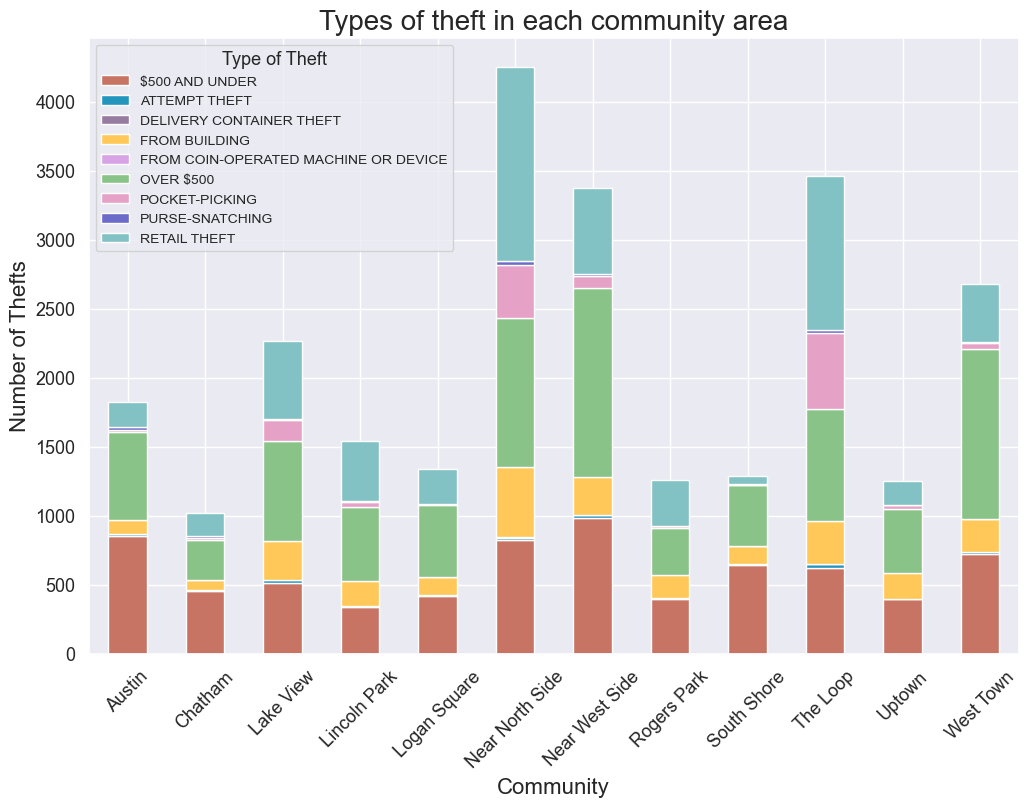

In [29]:
# Color palette
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]
sns.set_palette(sns.color_palette(colors))

# Stacked barplot
ax = theft_type.plot.bar(stacked = True, ylabel = 'Number of Thefts', figsize=(12, 8), xlabel = 'Community')
ax.tick_params(axis = 'both', labelsize = 13)
ax.tick_params(axis = 'x', labelrotation = 45)

# Labels for the plot
ax.legend(title = 'Type of Theft', fontsize=10, title_fontsize=13)
ax.set_xlabel('Community', fontsize=16)
ax.set_ylabel('Number of Thefts', fontsize=16)
ax.set_title('Types of theft in each community area', fontsize=20)

#### Analyzing the relationship between Population Density & Number of Thefts in a community area

In [30]:
# Create a dataframe with Community Names and their corresponding Number of Thefts
theft_counts_areas = pd.DataFrame(theft_community_data['Community Name'].value_counts())
theft_counts_areas = theft_counts_areas.reset_index()
theft_counts_areas.columns = ["Community Name", "Number of Thefts"]
theft_counts_areas.head(3) 

,Community Name,Number of Thefts
0,Near North Side,4251
1,The Loop,3464
2,Near West Side,3373


In [32]:
# Merge with community_areas dataset that includes the population density
theft_counts_areas['Community Name'] = theft_counts_areas['Community Name'].astype(str)
theft_with_density = theft_counts_areas.merge(community_areas, \
                                        left_on = 'Community Name', right_on = 'Community Name', how = 'left')
theft_with_density.head()

,Community Name,Number of Thefts,No.,Population,Area (sqmi),Area (sqkm),Density (sqmi),Density (sqkm)
0,Near North Side,4251,08,105481.0,2.74,7.10,38496.72,14863.58
1,The Loop,3464,NaN,NaN,NaN,NaN,NaN,NaN
2,Near West Side,3373,28,67881.0,5.69,14.74,11929.88,4606.13
3,West Town,2681,24,87781.0,4.58,11.86,19166.16,7400.05
4,Lake View,2268,06,103050.0,3.12,8.08,33028.85,12752.44


In [33]:
(theft_with_density.sort_values(by = 'Density (sqkm)', ascending = False)).head(12)
# Examining the top 12 community areas by population density (looking for the top 4 theft prone areas within these 12)

,Community Name,Number of Thefts,No.,Population,Area (sqmi),Area (sqkm),Density (sqmi),Density (sqkm)
0,Near North Side,4251,08,105481.0,2.74,7.10,38496.72,14863.58
4,Lake View,2268,06,103050.0,3.12,8.08,33028.85,12752.44
15,Edgewater,919,77,56296.0,1.74,4.51,32354.02,12491.89
9,Rogers Park,1257,01,55628.0,1.84,4.77,30232.61,11672.81
38,Albany Park,507,14,48396.0,1.92,4.97,25206.25,9732.13
10,Uptown,1255,03,57182.0,2.32,6.01,24647.41,9516.37
6,Lincoln Park,1541,07,70492.0,3.16,8.18,22307.59,8612.96
12,West Ridge,967,02,77122.0,3.53,9.14,21847.59,8435.36
55,Hermosa,287,20,24062.0,1.17,3.03,20565.81,7940.46
20,Belmont Cragin,768,19,78116.0,3.91,10.13,19978.52,7713.71


Text(0, 0.5, 'Number of Thefts')

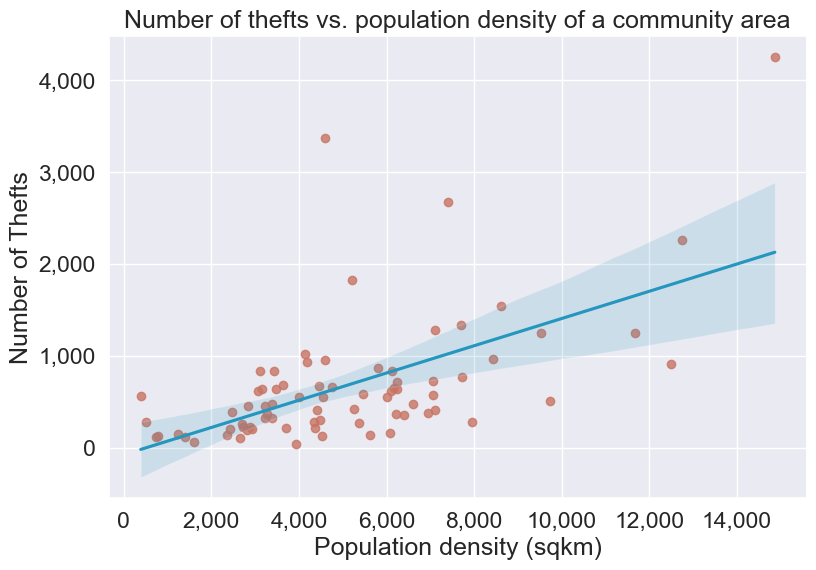

In [34]:
# Plotting all 77 community areas to view the correlation between number of thefts and population density
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(font_scale = 1.5)
ax = sns.regplot(x = 'Density (sqkm)', y = 'Number of Thefts', data = theft_with_density, scatter_kws = {'color':'#c87464'}, line_kws = {'color':'#2596be'})

# Plot labels
ax.set_title('Number of thefts vs. population density of a community area')
ax.xaxis.set_major_formatter('{x:,.0f}')
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_xlabel('Population density (sqkm)')
ax.set_ylabel('Number of Thefts')
    # Observing a positive correlation

In [37]:
top_12_areas_data['Description'].value_counts(normalize = True)
# Normalizing to see the percentages of total theft that each type of theft represents
# We can see that financial theft: theft over $500 and theft under $500 represents nearly 60% of total theft

Description
OVER $500                               0.330373
$500 AND UNDER                          0.280964
RETAIL THEFT                            0.224122
FROM BUILDING                           0.100814
POCKET-PICKING                          0.051600
ATTEMPT THEFT                           0.005985
PURSE-SNATCHING                         0.005594
DELIVERY CONTAINER THEFT                0.000352
FROM COIN-OPERATED MACHINE OR DEVICE    0.000196
Name: proportion, dtype: float64

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By \<Paisley Lucier>*

#### 1st visualization

In [112]:
# Visualizing proportion of crimes resulting in arrest across side
grouped_sides = arrest_data.groupby(['Side'])
grouped_sides_m = grouped_sides.mean()
grouped_sides_m

,ID,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
Side,,,,,,,,,,,,
Central,1.273337e+07,0.107993,0.164096,813.361489,7.901587,18.560827,38.129553,1.169315e+06,1.883294e+06,2022.0,41.835260,-87.654221
North,1.274061e+07,0.131305,0.166681,1798.788545,17.753468,35.142533,19.727479,1.151533e+06,1.919441e+06,2022.0,41.934816,-87.718521
South,1.270866e+07,0.108861,0.260033,791.395471,7.690781,14.362799,57.593862,1.178853e+06,1.846025e+06,2022.0,41.732781,-87.620367


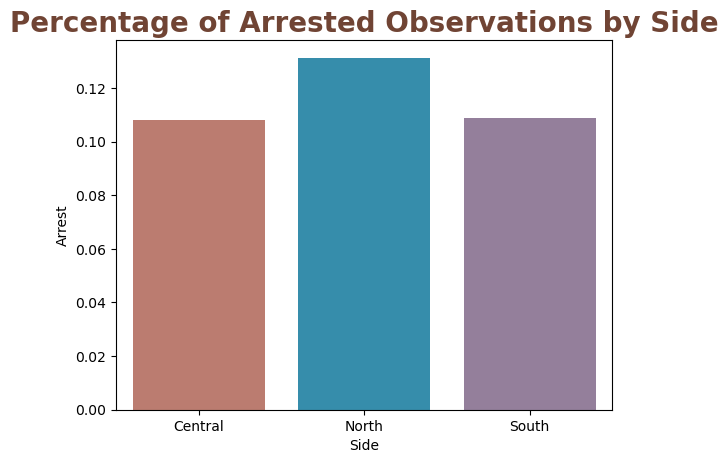

In [113]:
ax = sns.barplot(data=grouped_sides_m, x=grouped_sides_m.index, y='Arrest')
ax.set_title("Percentage of Arrested Observations by Side",
                  fontdict = {'fontsize': 20,
                              'fontweight': 'bold',
                              'color': '#704434'})
plt.show()

#### 2nd visualization


In [114]:
# to ensure that I am not comparing districts with almost 0 observances for a particular crime type, 
# I subset the top 12 crimes with the most overall observations

# be sure to show where this is coming from !!

In [115]:
# Subset top 12 crimes
top_12_crimes = arrest_data.loc[((arrest_data['Primary Type'] == 'THEFT') | \
                               (arrest_data['Primary Type'] == 'BATTERY') | \
                               (arrest_data['Primary Type'] == 'CRIMINAL DAMAGE') | \
                               (arrest_data['Primary Type'] == 'MOTOR VEHICLE THEFT') | \
                               (arrest_data['Primary Type'] == 'ASSAULT') | \
                               (arrest_data['Primary Type'] == 'DECEPTIVE PRACTICE') | \
                               (arrest_data['Primary Type'] == 'OTHER OFFENSE') | \
                               (arrest_data['Primary Type'] == 'ROBBERY') | \
                               (arrest_data['Primary Type'] == 'WEAPONS VIOLATION') | \
                               (arrest_data['Primary Type'] == 'BURGLARY') | \
                               (arrest_data['Primary Type'] == 'NARCOTICS') | \
                               (arrest_data['Primary Type'] == 'CRIMINAL TRESPASS')), :]

In [116]:
# Group observations by side, get average arrest rate for each top 12 crime type by side
grouped_side_type = top_12_crimes.groupby(['Side', 'Primary Type'])
grouped_side_type_m = grouped_side_type.mean().loc[:, 'Arrest']
grouped_side_type_m = grouped_side_type_m.reset_index() 

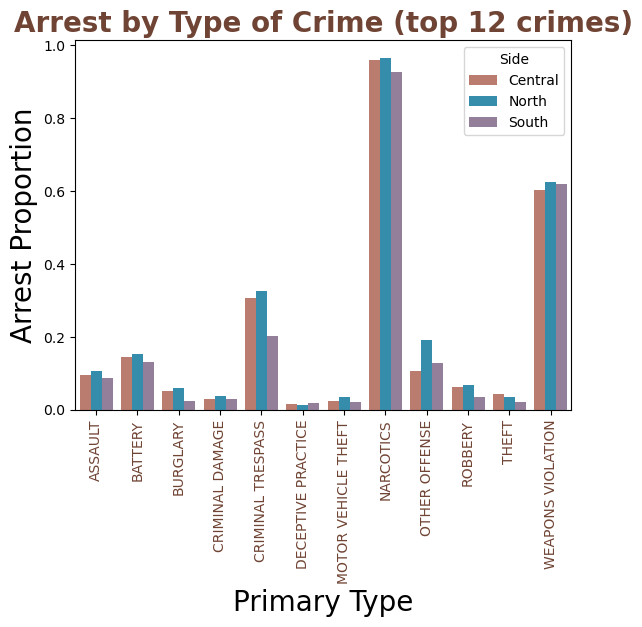

In [117]:
ax = sns.barplot(x='Primary Type',y='Arrest', hue='Side', data = grouped_side_type_m)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontdict = {
                              'color': '#704434'})
ax.set_title("Arrest by Type of Crime (top 12 crimes)",
                  fontdict = {'fontsize': 20,
                              'fontweight': 'bold',
                              'color': '#704434'})
ax.set_xlabel('Primary Type', fontsize=20)
ax.set_ylabel('Arrest Proportion', fontsize=20)

plt.show()

#### 3rd visualization

In [128]:
# Group by district
sentiments_2022_m = sentiments_2022.groupby(['DISTRICT']).mean()
sentiments_2022_m = sentiments_2022_m.reset_index()

# Add side column
sentiments_2022_m['Side'] = sentiments_2022_m['DISTRICT']
sentiments_2022_m['Side'] = sentiments_2022_m['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', 31: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})

In [129]:
# Group by side
sentiments_2022_m_side = sentiments_2022_m.groupby(['Side']).mean()
sentiments_2022_m_side = sentiments_2022_m_side.reset_index()
sentiments_2022_m_side.drop(columns='DISTRICT', inplace=True)

In [130]:
sentiments_2022_m_side_melted = pd.melt(sentiments_2022_m_side,id_vars = ['Side'],var_name = 'Survey_q',value_name = 'Score')


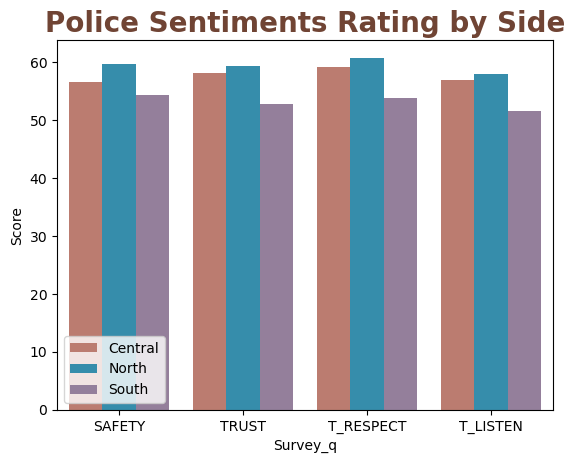

In [131]:
ax = sns.barplot(data=sentiments_2022_m_side_melted, x='Survey_q', y='Score', hue='Side')

ax.set_title("Police Sentiments Rating by Side",
                  fontdict = {'fontsize': 20,
                              'fontweight': 'bold',
                              'color': '#704434'})

plt.legend(loc='lower left')
plt.show()

#### 4th visualization

In [132]:
sentiments_arrest_dis = sentiments_2022_m.copy()
sentiments_arrest_dis = sentiments_arrest_dis.set_index('DISTRICT')
grouped = pd.DataFrame(top_12_crimes.groupby(['District', 'Primary Type']).mean().loc[:, 'Arrest'])
sentiments_arrest_dis.corr()

,SAFETY,TRUST,T_RESPECT,T_LISTEN
SAFETY,1.000000,0.915864,0.910727,0.914462
TRUST,0.915864,1.000000,0.996664,0.995943
T_RESPECT,0.910727,0.996664,1.000000,0.985276
T_LISTEN,0.914462,0.995943,0.985276,1.000000


In [133]:
# since these are highly correlated, I will aggregate to one score: average sentiment rating
sentiments_arrest_dis['avg_sent'] = (sentiments_arrest_dis['SAFETY'] + sentiments_arrest_dis['TRUST'] + \
                                    sentiments_arrest_dis['T_RESPECT'] + sentiments_arrest_dis['T_LISTEN']) / 4
sentiments_arrest_dis = sentiments_arrest_dis.drop(columns=['SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN'])
sentiments_arrest_dis

,Side,avg_sent
DISTRICT,,
1.0,Central,60.353594
2.0,Central,56.393281
3.0,Central,50.658646
4.0,South,52.999375
5.0,South,51.750729
6.0,South,50.812396
7.0,South,50.670885
8.0,Central,60.179896
9.0,Central,57.743646


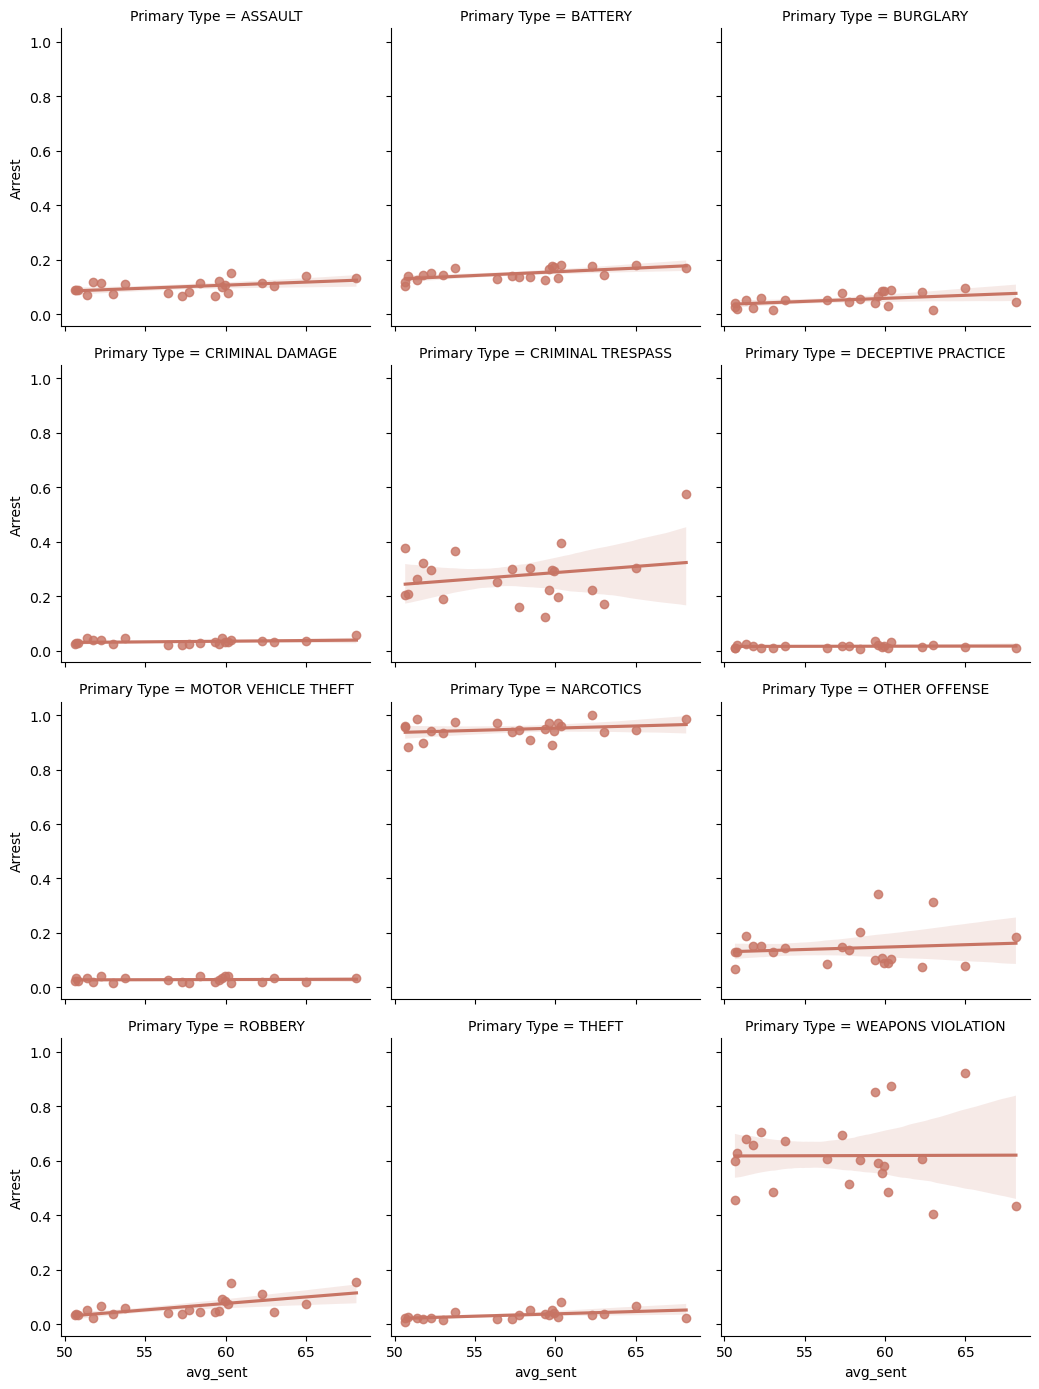

In [136]:
grouped = pd.DataFrame(top_12_crimes.groupby(['District', 'Primary Type']).mean().loc[:, 'Arrest'])

def merge_sentiments(x):
    x = pd.merge(left=x, right=sentiments_arrest_dis.reset_index(), left_on='District', right_on='DISTRICT')
    return x


grouped_new = grouped.reset_index().groupby('Primary Type').apply(merge_sentiments)
a = sns.FacetGrid(grouped_new, \
                  col = 'Primary Type',col_wrap=3,height=3.5,aspect = 1)
a.map_dataframe(sns.regplot,x="avg_sent", y="Arrest")
plt.show()

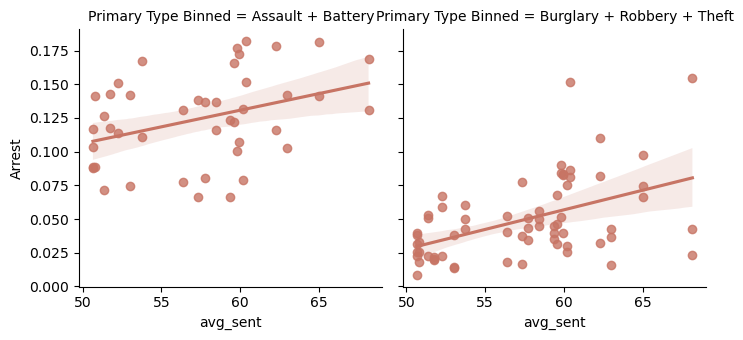

In [137]:
# binning the two types of crime with the most visible associations and graphing those for a closer look
grouped_new['Primary Type Binned'] = "None"
def bin_it(x):
    if (x['Primary Type'] == 'ASSAULT' or x['Primary Type'] == 'BATTERY'):
        x['Primary Type Binned'] = "Assault + Battery"
    elif (x['Primary Type'] == 'BURGLARY' or x['Primary Type'] == 'ROBBERY' or x['Primary Type'] == 'THEFT'):
        x['Primary Type Binned'] = "Burglary + Robbery + Theft"
    else:
        x['Primary Type Binned'] = x['Primary Type']
    return x
    
grouped_new = grouped_new.apply(bin_it, axis=1)
grouped_new = grouped_new.drop(columns = 'Primary Type')
grouped_new.reset_index()
grouped_new.groupby('Primary Type Binned')

a = sns.FacetGrid(grouped_new.loc[(grouped_new['Primary Type Binned']== 'Assault + Battery') \
                                  | (grouped_new['Primary Type Binned'] == 'Burglary + Robbery + Theft')], \
                  col = 'Primary Type Binned',col_wrap=3,height=3.5,aspect = 1)
a.map_dataframe(sns.regplot,x="avg_sent", y="Arrest")
plt.show()

#### 5th Visualization

In [138]:
grouped = pd.DataFrame(top_12_crimes.groupby(['Primary Type', 'District']).mean().loc[:, 'Arrest'])
grouped_reset = grouped.reset_index()

disparity_df = np.ones([grouped_reset['Primary Type'].nunique(), 4])
disparity_df = pd.DataFrame(disparity_df, columns=['Primary Type', 'District of Max Arrest Proportion', \
                                                   'District of Min Arrest Proportion', 'Difference'])
disparity_df['Primary Type'] = grouped_reset['Primary Type'].value_counts().index
disparity_df = disparity_df.set_index('Primary Type')

def get_disparity(x):
    maxx = x.Arrest.max()
    minn = x.Arrest.min()
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'District of Max Arrest Proportion'] = x.loc[x.Arrest.idxmax(), 'District']
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'District of Min Arrest Proportion'] = x.loc[x.Arrest.idxmin(), 'District']
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'Difference'] = maxx - minn
    
grouped_reset.groupby('Primary Type').apply(get_disparity)

disparity_df.sort_values(by = 'Difference', ascending = False)

,District of Max Arrest Proportion,District of Min Arrest Proportion,Difference
Primary Type,,,
WEAPONS VIOLATION,18.0,17.0,0.516396
CRIMINAL TRESPASS,16.0,22.0,0.449882
OTHER OFFENSE,14.0,3.0,0.272351
ROBBERY,16.0,5.0,0.134063
NARCOTICS,19.0,6.0,0.116667
ASSAULT,1.0,12.0,0.085086
BURGLARY,18.0,4.0,0.083151
BATTERY,1.0,7.0,0.078671
THEFT,1.0,7.0,0.072987


## Other sections

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.